In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import glob
import re

## TEST -- Read one file

In [2]:
df = pd.read_csv("50_variant_analysis/Quanta-100ng-1-aa_happy/Quanta-100ng-1-aa.roc.all.csv.gz")

In [3]:
df.head()

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,...,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
0,INDEL,*,*,ALL,*,CNN_2D,*,0.620173,0.808697,0.197562,...,43333.000000,NaN,1.144855,120677,.,.,51952.000000,67708.000000,NaN,0.767295
1,INDEL,*,*,ALL,*,CNN_2D,-0.191000,0.539400,0.854280,0.117634,...,.,NaN,NaN,53892,.,.,.,.,NaN,NaN
2,INDEL,*,*,ALL,*,CNN_2D,-0.692000,0.567674,0.844496,0.134068,...,.,NaN,NaN,66625,.,.,.,.,NaN,NaN
3,INDEL,*,*,ALL,*,CNN_2D,-1.193000,0.588574,0.835449,0.148820,...,.,NaN,NaN,78832,.,.,.,.,NaN,NaN
4,INDEL,*,*,ALL,*,CNN_2D,-1.694000,0.602765,0.827501,0.162059,...,.,NaN,NaN,90135,.,.,.,.,NaN,NaN


In [4]:
# 
data = df[(df.Type=="SNP") & (df.Filter=="ALL") & (df['QQ.Field'] == "CNN_2D") 
                          & (df['QQ'] != '*') & (df.Subset == "*")]
cols = ["METRIC.Recall", "METRIC.Precision", "QQ"]
data[cols] = data[cols].apply(pd.to_numeric, axis=1)
data = data.sort_values('QQ')

/Users/paalmbj/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
data = data[data['METRIC.Precision'] > data['METRIC.Precision'].shift(fill_value=0)]

In [6]:
data.head()

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,...,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
1823,SNP,*,*,ALL,*,CNN_2D,-16.118,0.763791,0.927981,0.063611,...,.,1.843194,NaN,202411,112285.000000,90336.000000,.,.,1.242971,NaN
1822,SNP,*,*,ALL,*,CNN_2D,-15.616,0.763729,0.928006,0.063163,...,.,NaN,NaN,200866,.,89471.000000,.,.,NaN,NaN
1821,SNP,*,*,ALL,*,CNN_2D,-15.115,0.763726,0.928008,0.063128,...,.,NaN,NaN,200748,.,89401.000000,.,.,NaN,NaN
1820,SNP,*,*,ALL,*,CNN_2D,-14.611,0.763725,0.928011,0.063092,...,.,NaN,NaN,200622,.,89323.000000,.,.,NaN,NaN
1819,SNP,*,*,ALL,*,CNN_2D,-14.109,0.763723,0.928015,0.063056,...,.,NaN,NaN,200499,.,.,.,.,NaN,NaN


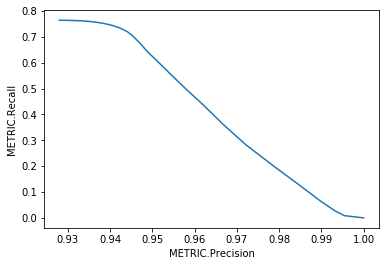

In [7]:
sns.lineplot(x="METRIC.Precision", y="METRIC.Recall", data=data)

In [8]:
xs = [row['METRIC.Precision'] for i, row in data.iterrows()]
ys = [row['METRIC.Recall'] for i, row in data.iterrows()]

In [9]:
ys[-3]

0.027342

Text(0, 0.5, 'Recall (Sensitivity) = TP / (TP + FN)')

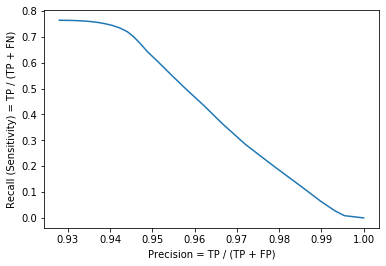

In [10]:
plt.plot(xs, ys)
plt.xlabel("Precision = TP / (TP + FP)")
plt.ylabel("Recall (Sensitivity) = TP / (TP + FN)")

## Read all the hap.py result files

Load data for SNP and INDEL groups (then subset later).

In [11]:
files = glob.glob("50_variant_analysis/*/*-aa.roc.all.csv.gz")
dataframes = []
for file in files:
    m = re.search(r"([^/]+)-(100?ng)-(\d)-aa\.", file)
    kit, conc, rep = m.groups()
    data = pd.read_csv(file)
    data = data[(data.Filter=="ALL") & (data['QQ.Field'] == "CNN_2D") 
                  & (data['QQ'] != '*') & (data.Subset == "*") & (data.Subtype == "*")]
    cols = ["METRIC.Recall", "METRIC.Precision", "QQ"]
    data = data[cols].apply(pd.to_numeric, axis=1).assign(Type=data.Type)
    data = data.groupby("Type", as_index=False).apply(lambda x: x.sort_values('QQ'))
    # Include higher QQ values until Precision starts dropping
    #stop = (data['METRIC.Precision'] > data['METRIC.Precision'].shift(fill_value=0)).idxmin()
    data = data[data['METRIC.Recall'] > 0.01]
    data['Kit'] = kit
    data['Conc'] = conc
    data['Replicate'] = rep
    dataframes.append(data)
data = pd.concat(dataframes)
data['Kit'] = pd.Categorical(data.Kit)


In [12]:
data.head()

METRIC.Recall  METRIC.Precision      QQ   Type      Kit   Conc Replicate
0 16       0.705143          0.857314 -16.118  INDEL  Nextera  100ng         2
  15       0.705139          0.857337 -15.588  INDEL  Nextera  100ng         2
  14       0.705139          0.857338 -15.026  INDEL  Nextera  100ng         2
  13       0.705138          0.857341 -14.441  INDEL  Nextera  100ng         2
  12       0.705138          0.857341 -13.940  INDEL  Nextera  100ng         2

### Distribution of QQ values in SNPs

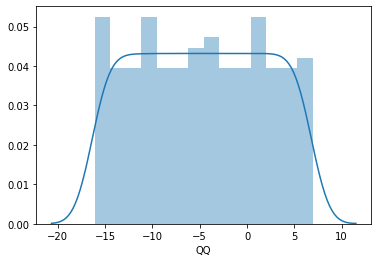

In [13]:
sns.distplot(data[data.Type=="SNP"].QQ)

In [14]:
data.Kit.cat.categories

Index(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S', 'Swiftlong'], dtype='object')

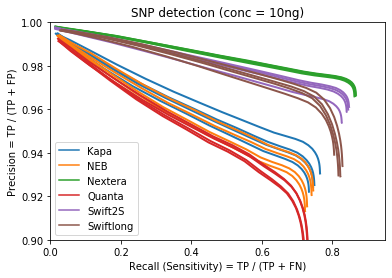

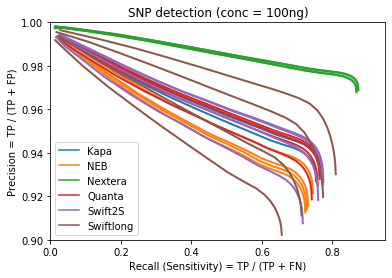

In [15]:
for conc in ["10ng", "100ng"]:
    plt.figure()
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", hue="Kit", 
                 style="Replicate", linewidth=2, dashes=False,
                 data=data[(data.Conc==conc) & (data.Type=="SNP")])
    plt.ylim(0.9, 1.0)
    plt.xlim(0.0, 0.95)
    plt.ylabel("Precision = TP / (TP + FP)")
    plt.xlabel("Recall (Sensitivity) = TP / (TP + FN)")
    plt.title("SNP detection (conc = {})".format(conc))
    g.legend_.remove()
    
    custom_lines = [Line2D([0], [0], color=colour)
                    for _, colour in 
                    zip(data.Kit.cat.categories, sns.color_palette())]
    plt.legend(custom_lines, data.Kit.cat.categories, loc="lower left")
    plt.savefig("plots/snp_detection_{}.pdf".format(conc))
    plt.show()


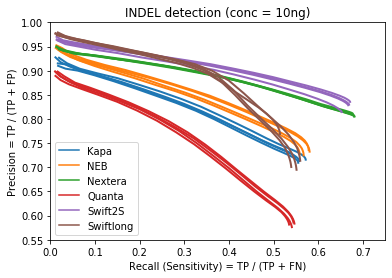

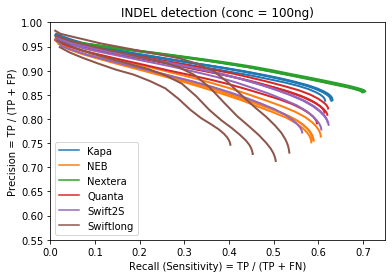

In [23]:
for conc in ["10ng", "100ng"]:
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", style="Replicate",
                 hue="Kit", linewidth=2, dashes=False,
                 data=data[(data.Conc==conc) & (data.Type == "INDEL")])
    plt.ylim(0.55, 1.0)
    plt.xlim(0.0, 0.75)
    plt.ylabel("Precision = TP / (TP + FP)")
    plt.xlabel("Recall (Sensitivity) = TP / (TP + FN)")
    plt.title("INDEL detection (conc = {})".format(conc))
    g.legend_.remove()

    custom_lines = [Line2D([0], [0], color=colour)
                for _, colour in 
                zip(data.Kit.cat.categories, sns.color_palette())]
    plt.legend(custom_lines, data.Kit.cat.categories, loc="lower left")
    plt.savefig("plots/indel_detection_{}.pdf".format(conc))
    plt.show()

In [17]:
data.head()

METRIC.Recall  METRIC.Precision      QQ   Type      Kit   Conc Replicate
0 16       0.705143          0.857314 -16.118  INDEL  Nextera  100ng         2
  15       0.705139          0.857337 -15.588  INDEL  Nextera  100ng         2
  14       0.705139          0.857338 -15.026  INDEL  Nextera  100ng         2
  13       0.705138          0.857341 -14.441  INDEL  Nextera  100ng         2
  12       0.705138          0.857341 -13.940  INDEL  Nextera  100ng         2

## Filtering

We need a more sane filter threshold. hap.py does not filter them for us!

First find the highest F1 value. Just for information, this is not necessarily an important selection.

Text(0.5, 1.0, 'Sensitivity & sensitivity at max F1')

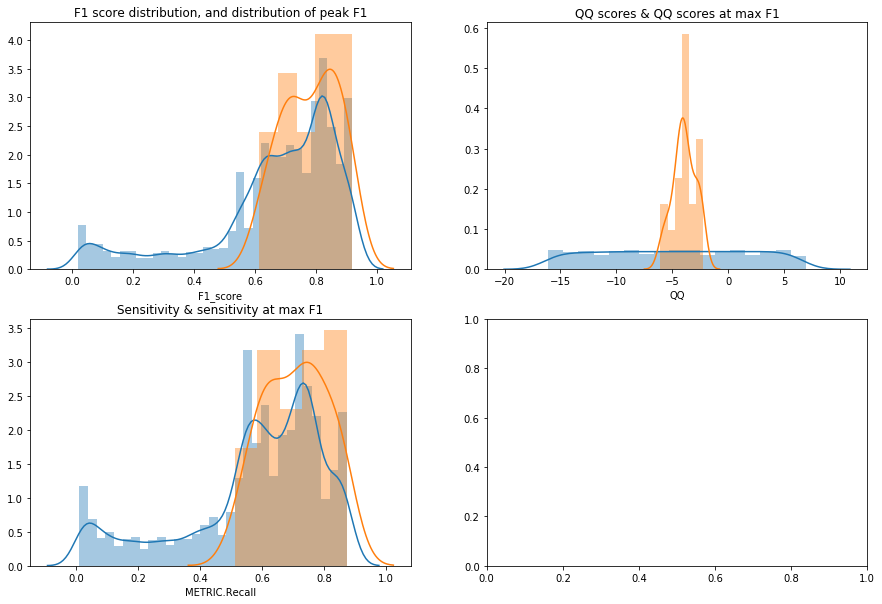

In [18]:
data['F1_score'] = 2*(data['METRIC.Recall'] * data['METRIC.Precision']) / (data['METRIC.Recall'] + data['METRIC.Precision'])
highest_f1 = data.groupby(["Type", "Kit", "Replicate"]).apply(
                    lambda x: x.sort_values('F1_score', ascending=False).head(n=1)
                )
f, axs = plt.subplots(2,2, figsize=(15,10))
sns.distplot(data['F1_score'], ax=axs[0,0])
sns.distplot(highest_f1.F1_score, ax=axs[0,0])
axs[0,0].set_title("F1 score distribution, and distribution of peak F1")
sns.distplot(data.QQ, ax=axs[0,1])
sns.distplot(highest_f1.QQ, ax=axs[0,1])
axs[0,1].set_title("QQ scores & QQ scores at max F1")
sns.distplot(data['METRIC.Recall'], ax=axs[1,0])
sns.distplot(highest_f1['METRIC.Recall'], ax=axs[1,0])
axs[1,0].set_title("Sensitivity & sensitivity at max F1")


## Tabular format

Using the a cut-off of CNN_2D (QQ score) > -5, for a comparable set of values.

In [19]:
quality_thres_mean = data.groupby(["Type", "Kit", "Conc"]).apply(
                    lambda x: x.groupby("Replicate").apply(lambda x: x[x.QQ > -5].iloc[0]).apply(
                        lambda x: x.mean()
                    )
                )

In [20]:
summary = quality_thres_mean[["METRIC.Recall", "METRIC.Precision", "QQ", "F1_score"]]
summary.to_clipboard()
summary

METRIC.Recall  METRIC.Precision       QQ  F1_score
Type  Kit       Conc                                                     
INDEL Kapa      100ng       0.625710          0.840529 -4.65050  0.717365
                10ng        0.557682          0.715647 -4.65000  0.626823
      NEB       100ng       0.591187          0.759545 -4.69775  0.664861
                10ng        0.570705          0.733085 -4.69650  0.641760
      Nextera   100ng       0.700290          0.857171 -4.71000  0.770826
                10ng        0.679342          0.807743 -4.83325  0.737995
      Quanta    100ng       0.612988          0.810171 -4.72750  0.697912
                10ng        0.541281          0.583067 -4.75175  0.561389
      Swift2S   100ng       0.603365          0.784706 -4.71775  0.682035
                10ng        0.664494          0.827977 -4.59100  0.737281
      Swiftlong 100ng       0.473702          0.731013 -4.61750  0.572979
                10ng        0.540860          0.721525 -4.85950  0.617557
SNP   Kapa      100ng       0.761090          0.931841 -4.58150  0.837849
                10ng        0.747166          0.928284 -4.57175  0.827908
      NEB       100ng       0.730455          0.919380 -4.57150  0.814089
                10ng        0.733258          0.921532 -4.56825  0.816670
      Nextera   100ng       0.869882          0.970319 -4.57950  0.917358
                10ng        0.863970          0.968362 -4.57525  0.913192
      Quanta    100ng       0.756428          0.928434 -4.57675  0.833637
                10ng        0.724336          0.897558 -4.57525  0.801691
      Swift2S   100ng       0.754941          0.923481 -4.57725  0.830637
                10ng        0.838854          0.960311 -4.58650  0.895473
      Swiftlong 100ng       0.737354          0.917802 -4.56175  0.816812
                10ng        0.817595          0.935756 -4.57700  0.872656

In [21]:
quality_thres_values = data.groupby(["Type", "Kit", "Conc"]).apply(
                    lambda x: x.groupby("Replicate").apply(lambda x: x[x.QQ > -5].iloc[0])
                )

In [22]:
#sns.boxplot(x="Kit", y="F1_score", )